# Time Series Forecasting with ARIMA

Time series provide the opportunity to forecast future values. Based on previous values, time series can be used to forecast trends.

One of the methods available to model and predict future points of a time series is known as SARIMAX, which stands for **Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors**. Here, we will primarily focus on the **ARIMA** component, which is used to fit time-series data to better understand and forecast future points in the time series.


## Data Pre-processing

### Import Dataset
We'll be working with a dataset from **Bentley**, which collected stock products with stock quantity sales from January 2012 to August 2017. In this case, we removed all the negative qty sales values before next step(**no-negativity**).

In [1]:
import pandas as pd
import warnings
import itertools
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

data = pd.read_csv('bentley_no_negative.csv')
data['Date'] = pd.to_datetime(pd.Series(data['Stock Trans Date']), format="%d/%m/%Y")
data = data.drop(['Stock Trans Date'],1)

/Users/cozg3/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/cozg3/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Select Specific Product or categories
In this step, selection is flexible. We can select the specific product based on "Stock Product Code", such as "BBQ.COVER/5", or select the whole category of "BBQ", in which all products including "BBQ" keyword will be selected.

In [2]:
best_sellers = ['BBQ.COVER/3',
                'LAD.06',
                'LAD.07',
                'PAT.01/C',
                'CAN.01/C',
                'GL/NB.01',
                'GL/BB.04',
                'CAIR.02/SS',
                'GL/SKB.01',
                'GL/FBG.02']

In [3]:
inputs = 'LAD.06'

In [4]:
#Select by partial string
#inputs = best_sellers[0]
select_data = data[data['Stock Product Code'].str.contains(inputs)]

In [5]:
select_data.head()

,Stock Product Code,Stock Qty Sales All,Date
9,LAD.06/BAG,3,2012-01-30
165,LAD.06/BAG,2,2012-02-02
204,LAD.06/BAG,1,2012-02-03
483,LAD.06/BAG,1,2012-02-07
681,LAD.06/BAG,1,2012-02-13


### Set Date as Index

In [6]:
select_data = select_data.set_index('Date')

In [7]:
select_data.head()

,Stock Product Code,Stock Qty Sales All
Date,,
2012-01-30,LAD.06/BAG,3
2012-02-02,LAD.06/BAG,2
2012-02-03,LAD.06/BAG,1
2012-02-07,LAD.06/BAG,1
2012-02-13,LAD.06/BAG,1


### Group the data in buckets by WEEK or MONTH

The 'MS' and 'W' string groups the data in buckets by start of the month and week respectively and then the averages of each bucket will be used for further analysis. 

In [8]:
# convert object into int datatype
select_data['Stock Qty Sales All']=select_data['Stock Qty Sales All'].astype(int)

#y = select_data['Stock Qty Sales All'].resample('MS').mean()
y = select_data['Stock Qty Sales All'].resample('W').sum()

In [9]:
y.isnull().sum()

5

In [10]:
y = y.fillna(0)

In [11]:
y.isnull().sum()

0

In [12]:
y.to_csv(inputs+'.csv')

### Visualizing Time-series Data

When working with time-series data, a lot can be revealed through visualizing it. A few things to look out for are: 

**seasonality**: does the data display a clear periodic pattern?

**trend**: does the data follow a consistant upwards or downward slope?

**noise**: are there any outlier points or missing values that are not consistent with the rest of the data?

Some distinguishable patterns appear when we plot the data. The time-series has an obvious seasonality pattern, as well as an increasing trend before first half year of 2014 and then decreasing trend. We can also visualize our data using a method called time-series decomposition. As its name suggests, time series decomposition allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

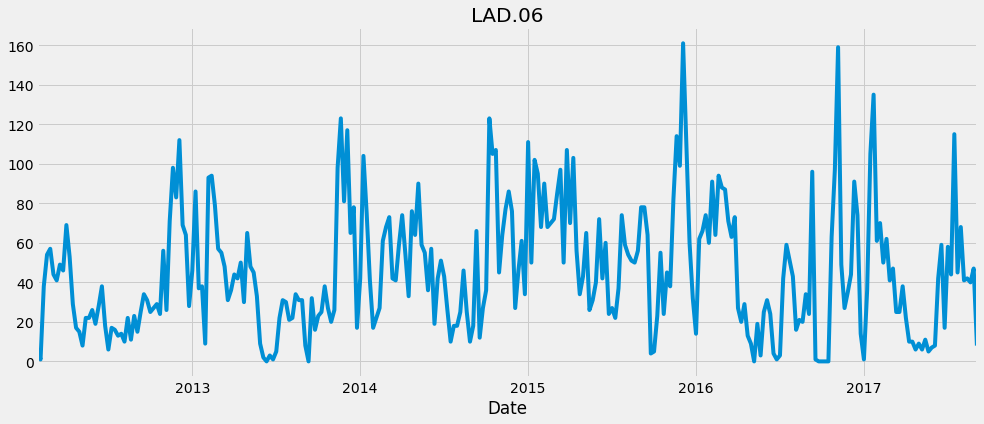

In [24]:
y.plot(figsize=(15,6))
plt.title(inputs)
plt.show()

### Seasonal-Trend Decomposition
The reference for its original implementation can be found in the following paper, "[STL: A Seasonal-Trend Decomposition Procedure Based on Loess.](https://www.wessa.net/download/stl.pdf)" Python library `statsmodels` provides the convenient `seasonal_decompose` function to perform seasonal decomposition out of the box.

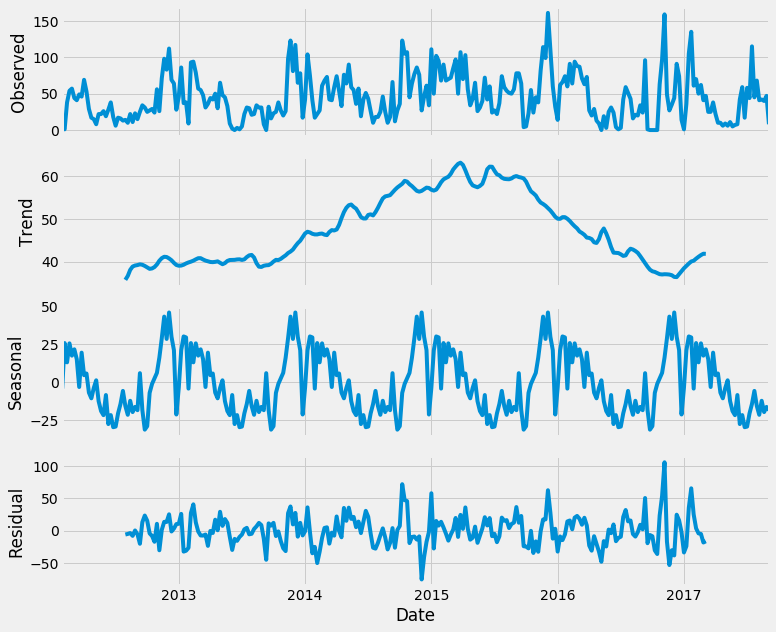

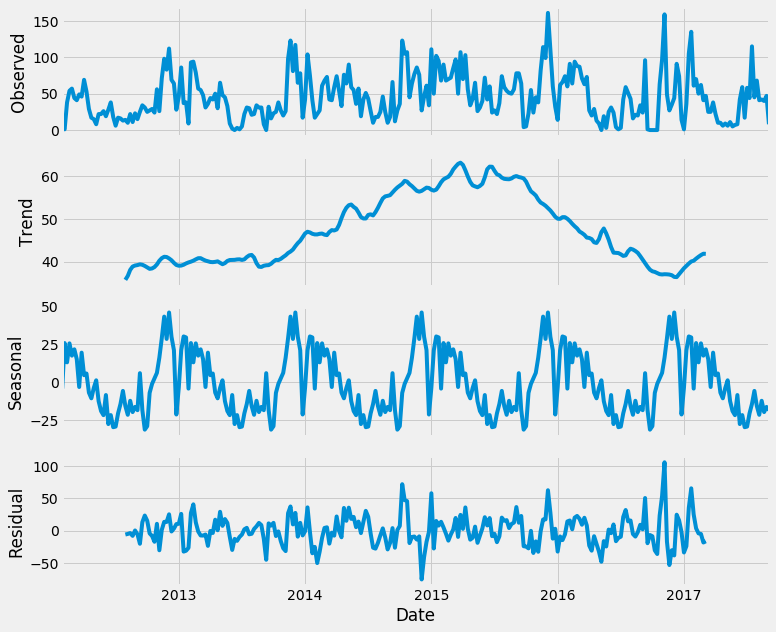

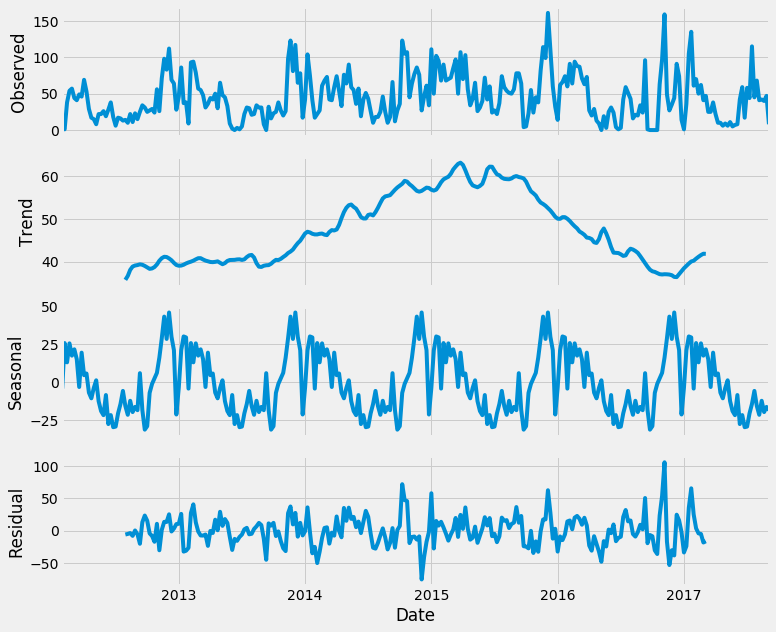

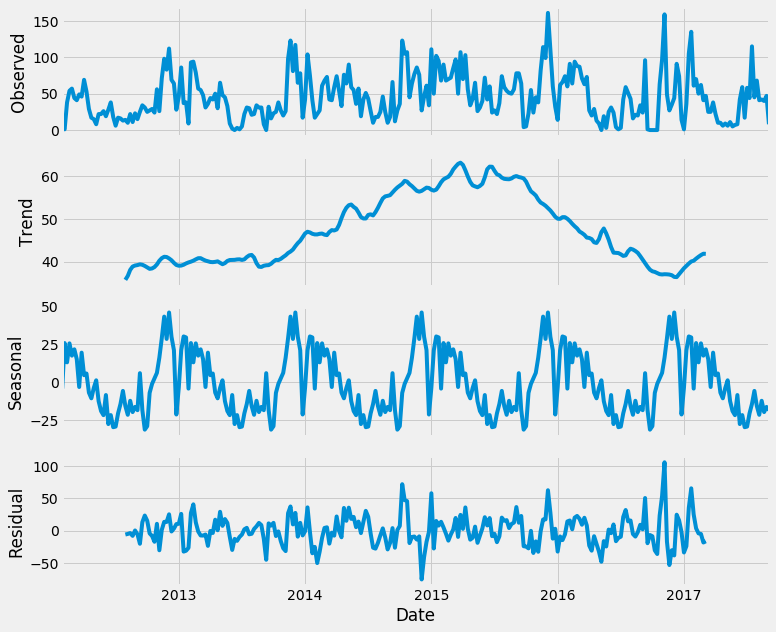

In [28]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 11,9

decomposition = sm.tsa.seasonal_decompose(y,model='additive')
fig = decomposition.plot()
#plt.savefig("/Users/cozg3/Documents/Time-Series-Forecasting/decom.png")
plt.show()

Using time-series decomposition makes it easier to quickly identify a changing mean or variation in the data. The plot above clearly shows the upwards trend of our data, along with its yearly seasonality. These can be used to understand the structure of our time-series. The intuition behind time-series decomposition is important, as many forecasting methods build upon this concept of structured decomposition to produce forecasts.

## The ARIMA Time Series Model

One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for **A**utoreg**R**essive **I**ntegrated **M**oving **A**verage. **ARIMA** is a model that can be fitted to time series data in order to better understand or predict future points in the series.

There are three distinct integers(`p`,`d`,`q`) that are used to parametrize ARIMA models. Becasue of that, ARIMA models are denoted with the notation `ARIMA(p,d,q)`. Together these three parameters account for seasonality, trend and noise in datasets:

`P` is the **auto-regressive** part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.

`d` is the **integrated** part of the model. This includes terms in the model that incorporate the amount of differencing(i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.

`q` is the **moving average** part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

## Parameter Selection for the ARIMA Model

We will use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the `SARIMAX()` function from the `statsmodels` module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest.

In [15]:
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We can now use the triplets of parameters defined above to automate the process of training and evaluating ARIMA models on different combinations. In Statistics and Machine Learning, this process is known as **grid search** (or hyperparameter optimization) for model selection.

When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. We will use the `AIC` (**Akaike Information Criterion**) value, which is conveniently returned with ARIMA models fitted using `statsmodels`. The `AIC` measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest `AIC` value.

The code chunk below iterates through combinations of parameters and uses the `SARIMAX` function from statsmodels to fit the corresponding Seasonal ARIMA model. Here, the order argument specifies the `(p, d, q)` parameters, while the seasonal_order argument specifies the `(P, D, Q, S)` seasonal component of the Seasonal ARIMA model. After fitting each SARIMAX() model, the code prints out its respective `AIC` score.

In [16]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2930.4795830156654
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2626.3201973500372
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2845.2739121322506
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2745.6241358011503
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2730.5280021178955
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2628.0492034216404
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2968.669272053535
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2788.440336168309
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2788.5975877668184
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2543.6291827097452
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2753.678329353839
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2658.964847051534
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2650.7391565491503
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2545.4460920903916
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2653.8172788056104
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:2558.541775103493
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:2662.270618367419
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:2655.734752573525

The output of our code suggests that `SARIMAX(1, 1, 1)x(1, 1, 1, 12)` yields the lowest AIC value of 1023.32. We should therefore consider this to be optimal option out of all the models we have considered.

## Fitting an ARIMA Time Series Model


Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

In [17]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5695      0.044     13.017      0.000       0.484       0.655
ma.L1         -0.9696      0.021    -46.696      0.000      -1.010      -0.929
ar.S.L12       0.0023      0.040      0.058      0.954      -0.076       0.081
ma.S.L12      -1.0000    265.276     -0.004      0.997    -520.931     518.931
sigma2       630.0246   1.67e+05      0.004      0.997   -3.27e+05    3.28e+05


The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we'll focus our attention on the table of **coefficients**. The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The **P>|z|** column informs us of the significance of each feature weight.

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

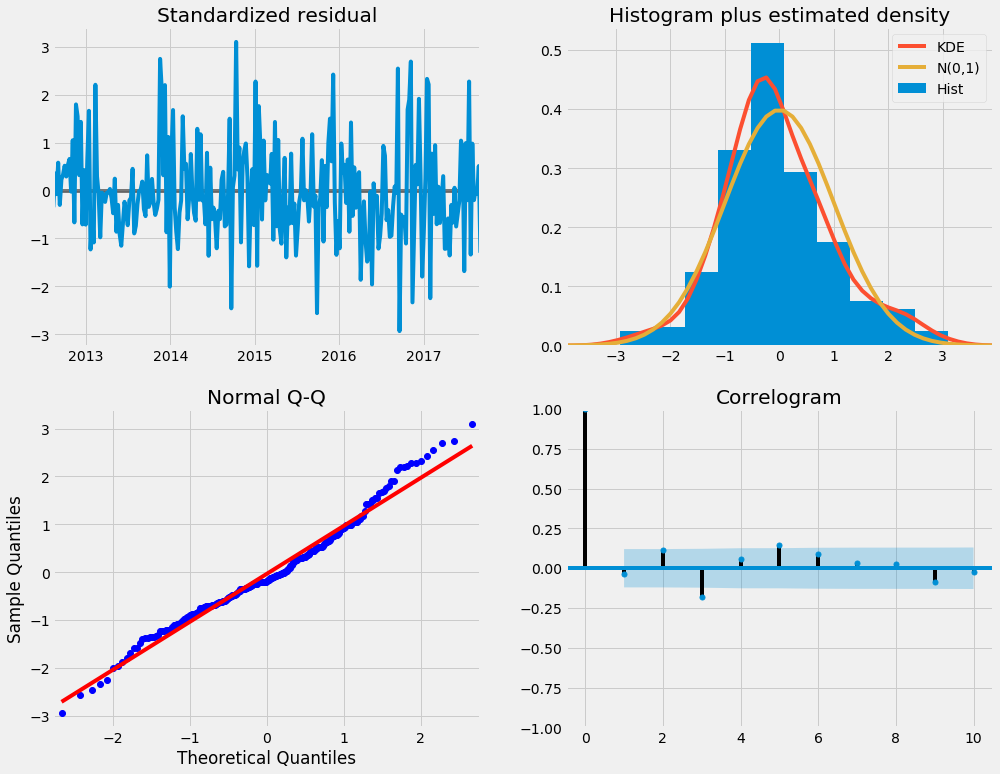

In [18]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

### Improve
Although we have a satisfactory fit, some parameters of our seasonal ARIMA model could be changed to improve our model fit. For example, our grid search only considered a restricted set of parameter combinations, so we may find better models if we widened the grid search.

## Validating Forecasts

We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. 

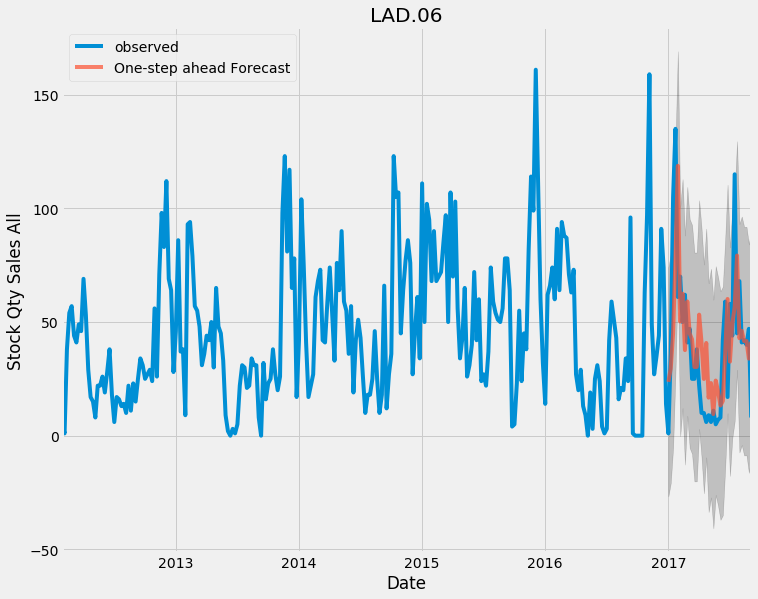

In [19]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Stock Qty Sales All')
plt.legend()
plt.title(inputs)
plt.savefig('1.png')
plt.show()

In [19]:
data = pred.predicted_mean

#data.to_csv('pred.csv')

Overall, our forecasts align with the true values very well.

It is also useful to quantify the accuracy of our forecasts. We will use the **MSE** (Mean Squared Error), which summarizes the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [20]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 753.76


The MSE of our one-step ahead forecasts yields a value of 0.55, which is very low as it is close to 0. An MSE of 0 would that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible.

## Producing and Visualizing Forests

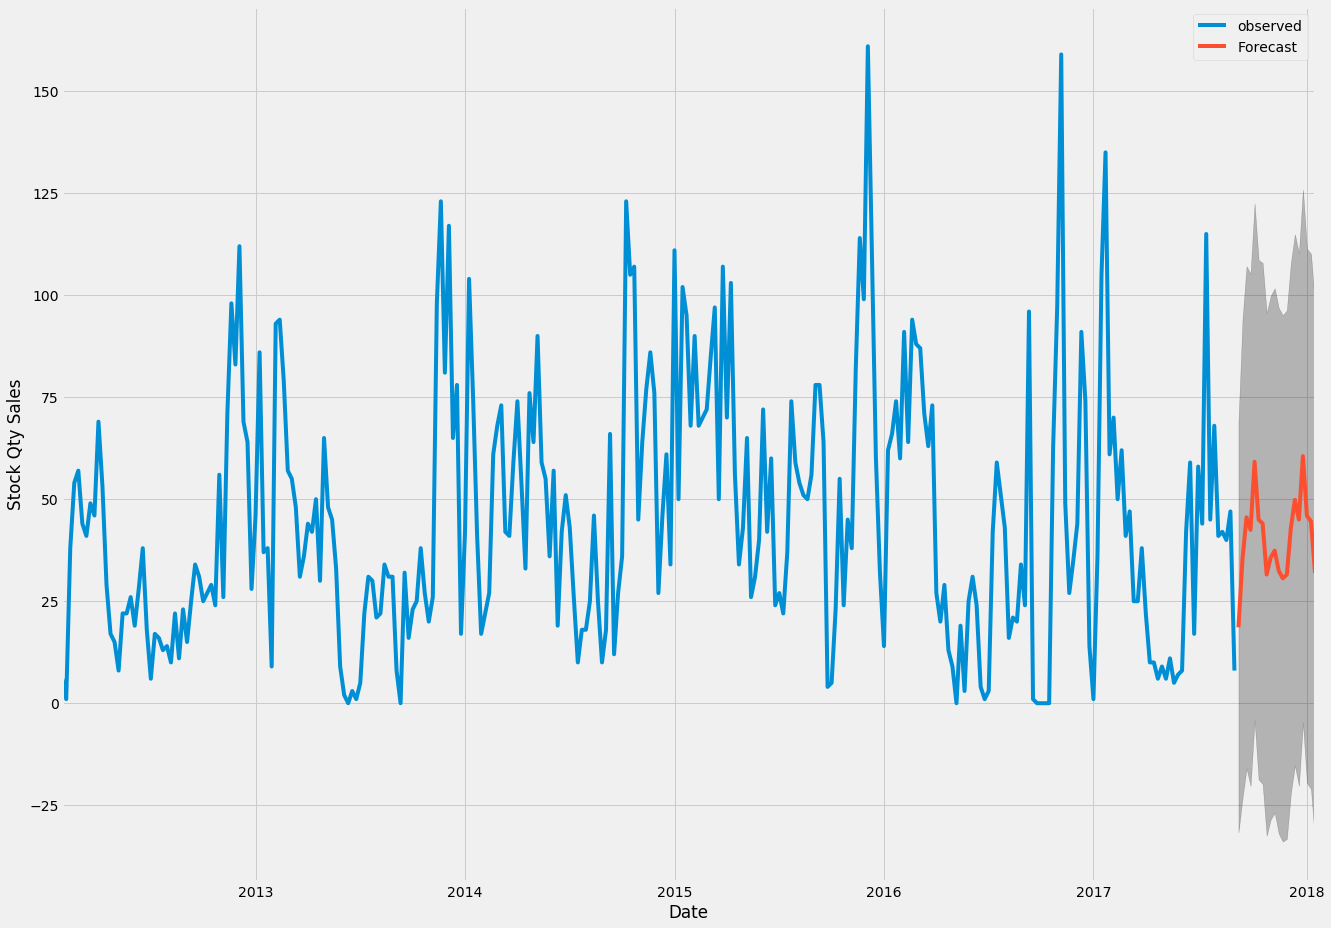

In [21]:
# Get forecast 20 steps ahead in future
pred_uc = results.get_forecast(steps=20)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Stock Qty Sales')

plt.legend()
plt.show()

In [22]:
data = pred_uc.predicted_mean

In [23]:
data.columns = ["Date","Prediction"]

In [24]:
print(data)

2017-09-10     7.759683
2017-09-17    12.638920
2017-09-24    17.089017
2017-10-01    22.259598
2017-10-08    13.326326
2017-10-15     9.569641
2017-10-22    11.759193
2017-10-29     7.609067
2017-11-05    16.304735
2017-11-12    23.126476
2017-11-19    11.386129
2017-11-26     7.573456
2017-12-03     7.257676
2017-12-10    12.647705
2017-12-17    17.178041
2017-12-24    22.423524
2017-12-31    13.470001
2018-01-07     9.810713
2018-01-14    11.907433
2018-01-21     7.797930
2018-01-28    16.433979
2018-02-04    23.226078
2018-02-11    11.538134
2018-02-18     7.770640
2018-02-25     7.439906
2018-03-04    12.825966
2018-03-11    17.355678
2018-03-18    22.600579
2018-03-25    13.647214
2018-04-01     9.987169
2018-04-08    12.084610
2018-04-15     7.974791
2018-04-22    16.611304
2018-04-29    23.403633
2018-05-06    11.715282
2018-05-13     7.947437
2018-05-20     7.616819
2018-05-27    13.002909
2018-06-03    17.532626
2018-06-10    22.777532
2018-06-17    13.824166
2018-06-24    10

In [71]:
data = pd.DataFrame([data], columns = ["A","B"])

In [72]:
data.head()

,A,B
0,NaN,NaN


In [64]:
product_code = 'BBQ'
data['Name'] = product_code

In [89]:
name = 'Orange'

In [90]:
data.to_csv(name+'.csv')